**PROJECT TITLE: PREDICTING BED SPACE UTILIZATION RATE DURING COVID-19 PANDEMIC IN THE US**



# PROJECT DESCRIPTION:

We acquire two different datasets: The licence bed dataset and the number of cases/deaths recorded dataset. What the datasets has in common were the distribution of the dataset across the counties and the respective states.
The development of this model went through a process which is simply put below:

**Data Cleaning -> Data visualization -> Model Building with Sage Maker(Initiating model instance, parameter tuning, model testing, model deployment model testing and endpoint termination)** 

In [159]:
#importing the needed libraries
import pandas as pd
import numpy as np
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
import io
from sagemaker import get_execution_role
import os

# Amazon SageMaker Python SDK
import sagemaker.amazon.common as smac 
import sagemaker

# instruction to Jupyter to inline all the visualizations
%matplotlib inline 

## **Data Wrangling**

In [160]:
#Declaring access key and bucket name
#Loading Raw data from bucket
role = get_execution_role()
input_bucket = 'covid.data2020'
data_key = 'key1.csv'
data_bed = 'USAHospitalBeds_U.csv'
data_cases = 'us_counties.csv'
bed_data = 's3://{}/{}'.format(input_bucket, data_bed)
cases_data = 's3://{}/{}'.format(input_bucket, data_cases)
key_data = 's3://{}/{}'.format(input_bucket, data_key)

# Define the headers since the data does not have any
#headers = ['CommittedCrime','County','TimeofDay','DayofWeek','Month','Gender','AverageAge']

dcases = pd.read_csv(bed_data)
dbed = pd.read_csv(cases_data)
print('uploaded training data from location: {}'.format(data_key))

uploaded training data from location: key1.csv


In [161]:
dcases.head(5)

,X,Y,OBJECTID,HOSPITAL_NAME,HOSPITAL_TYPE,HQ_ADDRESS,HQ_ADDRESS1,HQ_CITY,HQ_STATE,HQ_ZIP_CODE,...,CNTY_FIPS,FIPS,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
0,-112.066157,33.495498,1,Phoenix VA Health Care System (AKA Carl T Hayd...,VA Hospital,650 E Indian School Rd,NaN,Phoenix,AZ,85012,...,13.0,4013.0,62.0,62.0,0,0,NaN,NaN,0,0
1,-110.965885,32.181263,2,Southern Arizona VA Health Care System,VA Hospital,3601 S 6th Ave,NaN,Tucson,AZ,85723,...,19.0,4019.0,295.0,295.0,2,2,NaN,NaN,0,2
2,-119.779742,36.773323,3,VA Central California Health Care System,VA Hospital,2615 E Clinton Ave,NaN,Fresno,CA,93703,...,19.0,6019.0,54.0,54.0,2,2,NaN,NaN,0,2
3,-72.957610,41.284400,4,VA Connecticut Healthcare System - West Haven ...,VA Hospital,950 Campbell Ave,NaN,West Haven,CT,6516,...,9.0,9009.0,216.0,216.0,1,1,NaN,NaN,0,2
4,-75.606533,39.740206,5,Wilmington VA Medical Center,VA Hospital,1601 Kirkwood Hwy,NaN,Wilmington,DE,19805,...,3.0,10003.0,62.0,62.0,0,0,NaN,NaN,0,1


In [162]:
#Death and number cases data table visualization
dbed.head(5)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [163]:
dcases.columns

Index(['X', 'Y', 'OBJECTID', 'HOSPITAL_NAME', 'HOSPITAL_TYPE', 'HQ_ADDRESS',
       'HQ_ADDRESS1', 'HQ_CITY', 'HQ_STATE', 'HQ_ZIP_CODE', 'COUNTY_NAME',
       'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS', 'FIPS', 'NUM_LICENSED_BEDS',
       'NUM_STAFFED_BEDS', 'NUM_ICU_BEDS', 'ADULT_ICU_BEDS', 'PEDI_ICU_BEDS',
       'BED_UTILIZATION', 'Potential_Increase_In_Bed_Capac',
       'AVG_VENTILATOR_USAGE'],
      dtype='object')

In [164]:
dbed.columns

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths'], dtype='object')

In [165]:
dcases1 = dcases.drop(['OBJECTID','X','Y','STATE_FIPS','FIPS','CNTY_FIPS','HQ_ADDRESS','HOSPITAL_NAME','HOSPITAL_TYPE','HQ_ADDRESS1',
               'HQ_CITY',"HQ_STATE","HQ_ZIP_CODE"], axis=1)

In [166]:
dbed1 = dbed.drop(['date','fips'], axis = 1)

In [167]:
dcases1.columns

Index(['COUNTY_NAME', 'STATE_NAME', 'NUM_LICENSED_BEDS', 'NUM_STAFFED_BEDS',
       'NUM_ICU_BEDS', 'ADULT_ICU_BEDS', 'PEDI_ICU_BEDS', 'BED_UTILIZATION',
       'Potential_Increase_In_Bed_Capac', 'AVG_VENTILATOR_USAGE'],
      dtype='object')

In [168]:
dcases1.describe

<bound method NDFrame.describe of      COUNTY_NAME    STATE_NAME  NUM_LICENSED_BEDS  NUM_STAFFED_BEDS  \
0       Maricopa       Arizona               62.0              62.0   
1           Pima       Arizona              295.0             295.0   
2         Fresno    California               54.0              54.0   
3      New Haven   Connecticut              216.0             216.0   
4     New Castle      Delaware               62.0              62.0   
...          ...           ...                ...               ...   
6617     Bastrop         Texas                NaN               NaN   
6618       Berks  Pennsylvania                NaN               NaN   
6619   Jefferson         Texas                NaN               NaN   
6620        Webb         Texas                NaN               NaN   
6621       Clark        Nevada                NaN               NaN   

      NUM_ICU_BEDS  ADULT_ICU_BEDS  PEDI_ICU_BEDS  BED_UTILIZATION  \
0                0               0         

In [169]:
dcases1.isnull().sum()

COUNTY_NAME                         25
STATE_NAME                          25
NUM_LICENSED_BEDS                  151
NUM_STAFFED_BEDS                   239
NUM_ICU_BEDS                         0
ADULT_ICU_BEDS                       0
PEDI_ICU_BEDS                      739
BED_UTILIZATION                    713
Potential_Increase_In_Bed_Capac      0
AVG_VENTILATOR_USAGE                 0
dtype: int64

In [170]:
dcases2 = dcases1.groupby(['STATE_NAME','COUNTY_NAME']).sum()

In [171]:
dcases2.head(10)

NUM_LICENSED_BEDS  NUM_STAFFED_BEDS  NUM_ICU_BEDS  \
STATE_NAME COUNTY_NAME                                                      
Alabama    Autauga                   85.0              55.0             6   
           Baldwin                  386.0             362.0            51   
           Barbour                   74.0              30.0             5   
           Bibb                      35.0              25.0             4   
           Blount                    25.0              25.0             6   
           Bullock                   61.0              30.0             5   
           Butler                    72.0              44.0             7   
           Calhoun                  486.0             435.0            30   
           Chambers                 115.0              84.0            15   
           Cherokee                  60.0              45.0             8   

                        ADULT_ICU_BEDS  PEDI_ICU_BEDS  BED_UTILIZATION  \
STATE_NAME COUNTY_NAME                                                   
Alabama    Autauga                   6            0.0         0.623113   
           Baldwin                  51            0.0         2.248812   
           Barbour                   5            0.0         0.378721   
           Bibb                      4            0.0         0.430904   
           Blount                    6            0.0         0.499069   
           Bullock                   5            0.0         0.212877   
           Butler                    7            0.0         0.187111   
           Calhoun                  30            0.0         1.294690   
           Chambers                 15            0.0         0.398726   
           Cherokee                  8            0.0         0.242532   

                        Potential_Increase_In_Bed_Capac  AVG_VENTILATOR_USAGE  
STATE_NAME COUNTY_NAME                                                         
Alabama    Autauga                                   30                     2  
           Baldwin                                   24                     8  
           Barbour                                   44                     2  
           Bibb                                      10                     1  
           Blount                                     0                     2  
           Bullock                                   31                     1  
           Butler                                    28                     2  
           Calhoun                                   51                    15  
           Chambers                                  31                     0  
           Cherokee                                  15                     1

In [172]:
dbed1.head(5)

,county,state,cases,deaths
0,Snohomish,Washington,1,0
1,Snohomish,Washington,1,0
2,Snohomish,Washington,1,0
3,Cook,Illinois,1,0
4,Snohomish,Washington,1,0


## **Data Visualization**

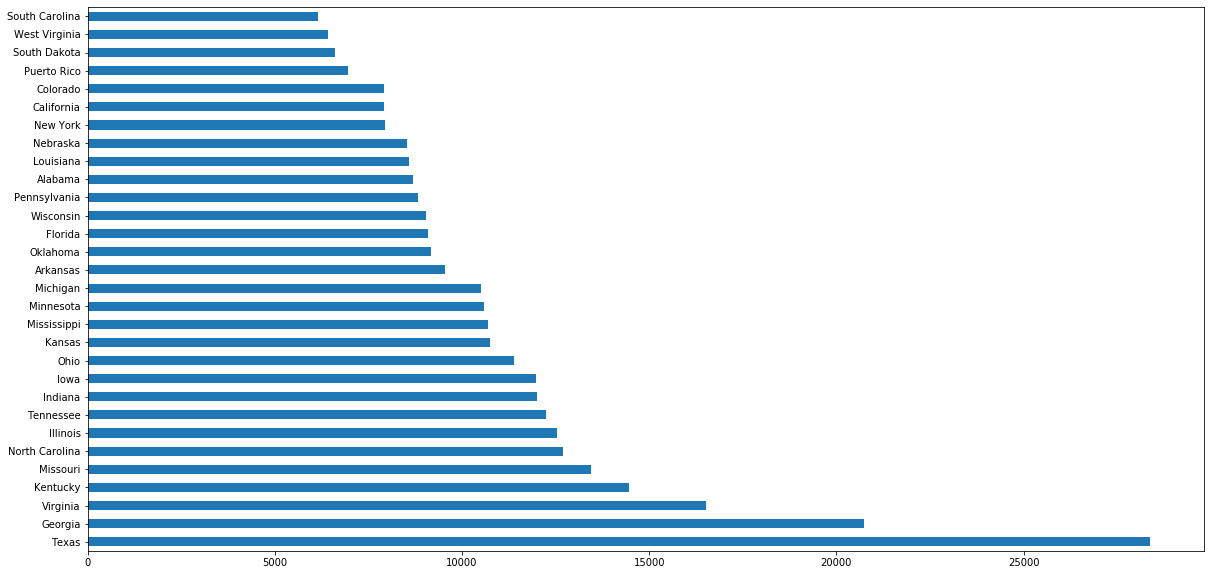

In [173]:
dbed1['state'].value_counts().head(30).plot(kind='barh', figsize=(20,10))

In [174]:
summary_cases = (dbed1.groupby(['state', 'cases']).size().to_frame('case count').reset_index())

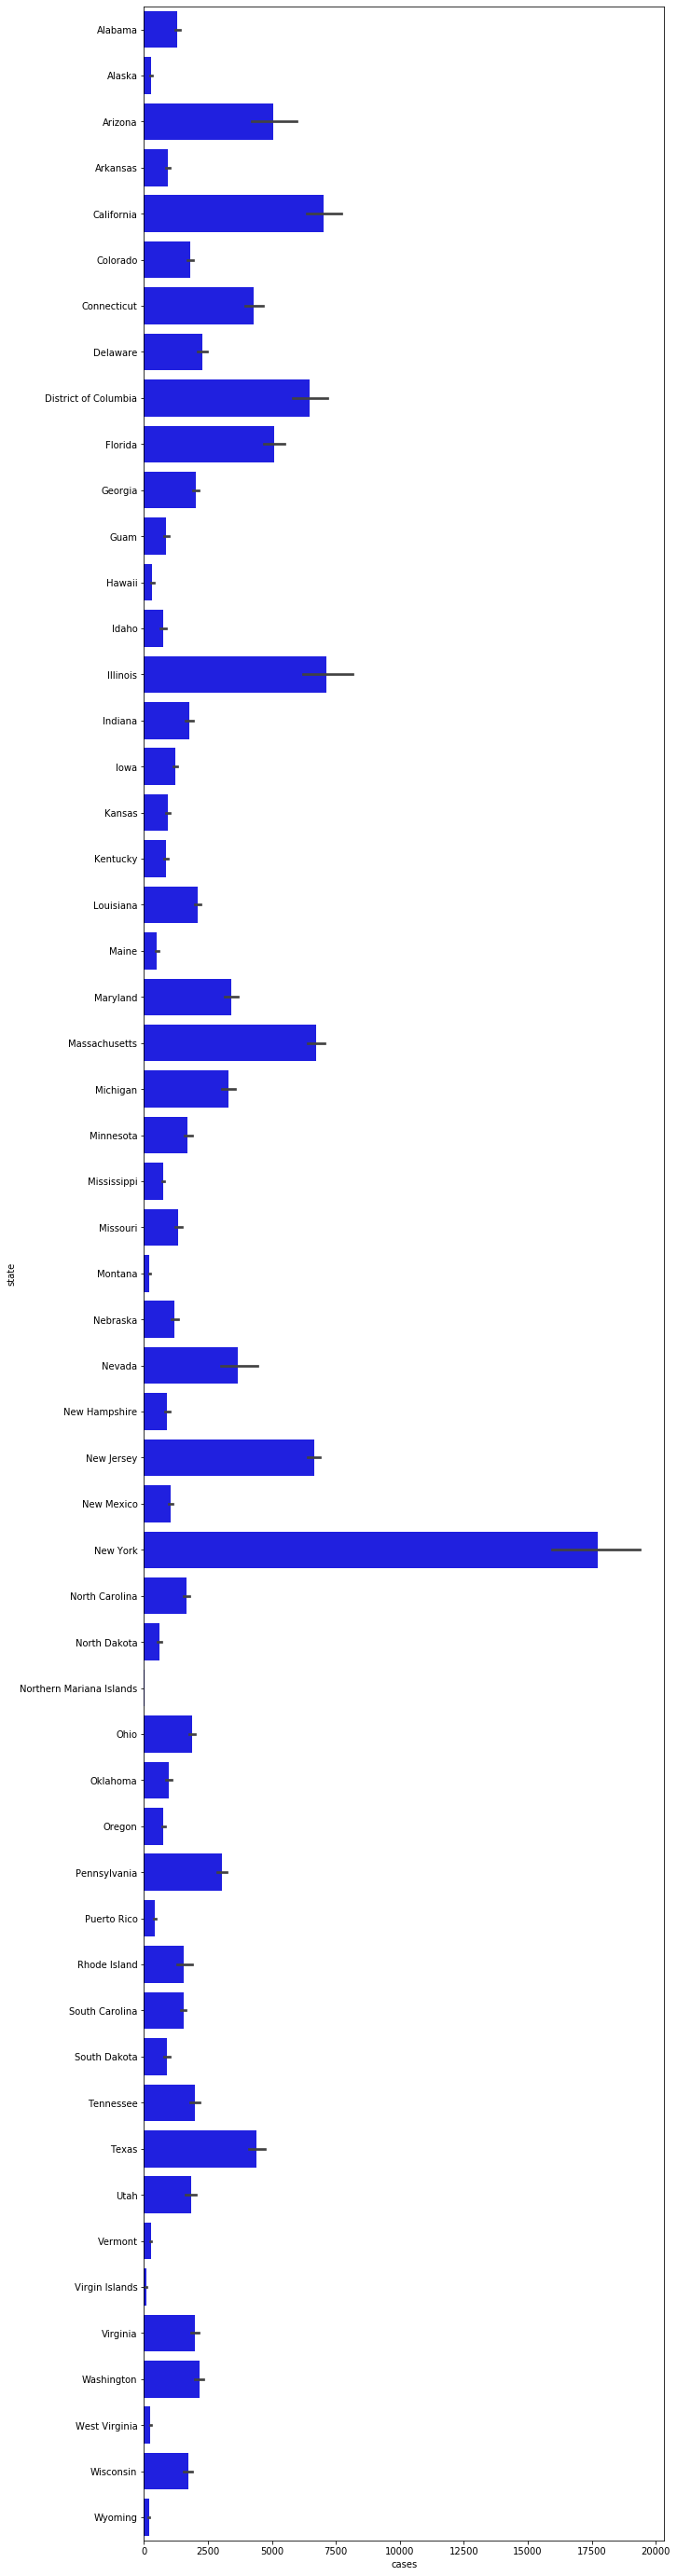

In [175]:
plt.figure(figsize=(10,50))
sns.barplot(data=summary_cases, x='cases',y='state', color='blue')

In [176]:
summary_death = (dbed1.groupby(['state', 'deaths']).size().to_frame('death count').reset_index())

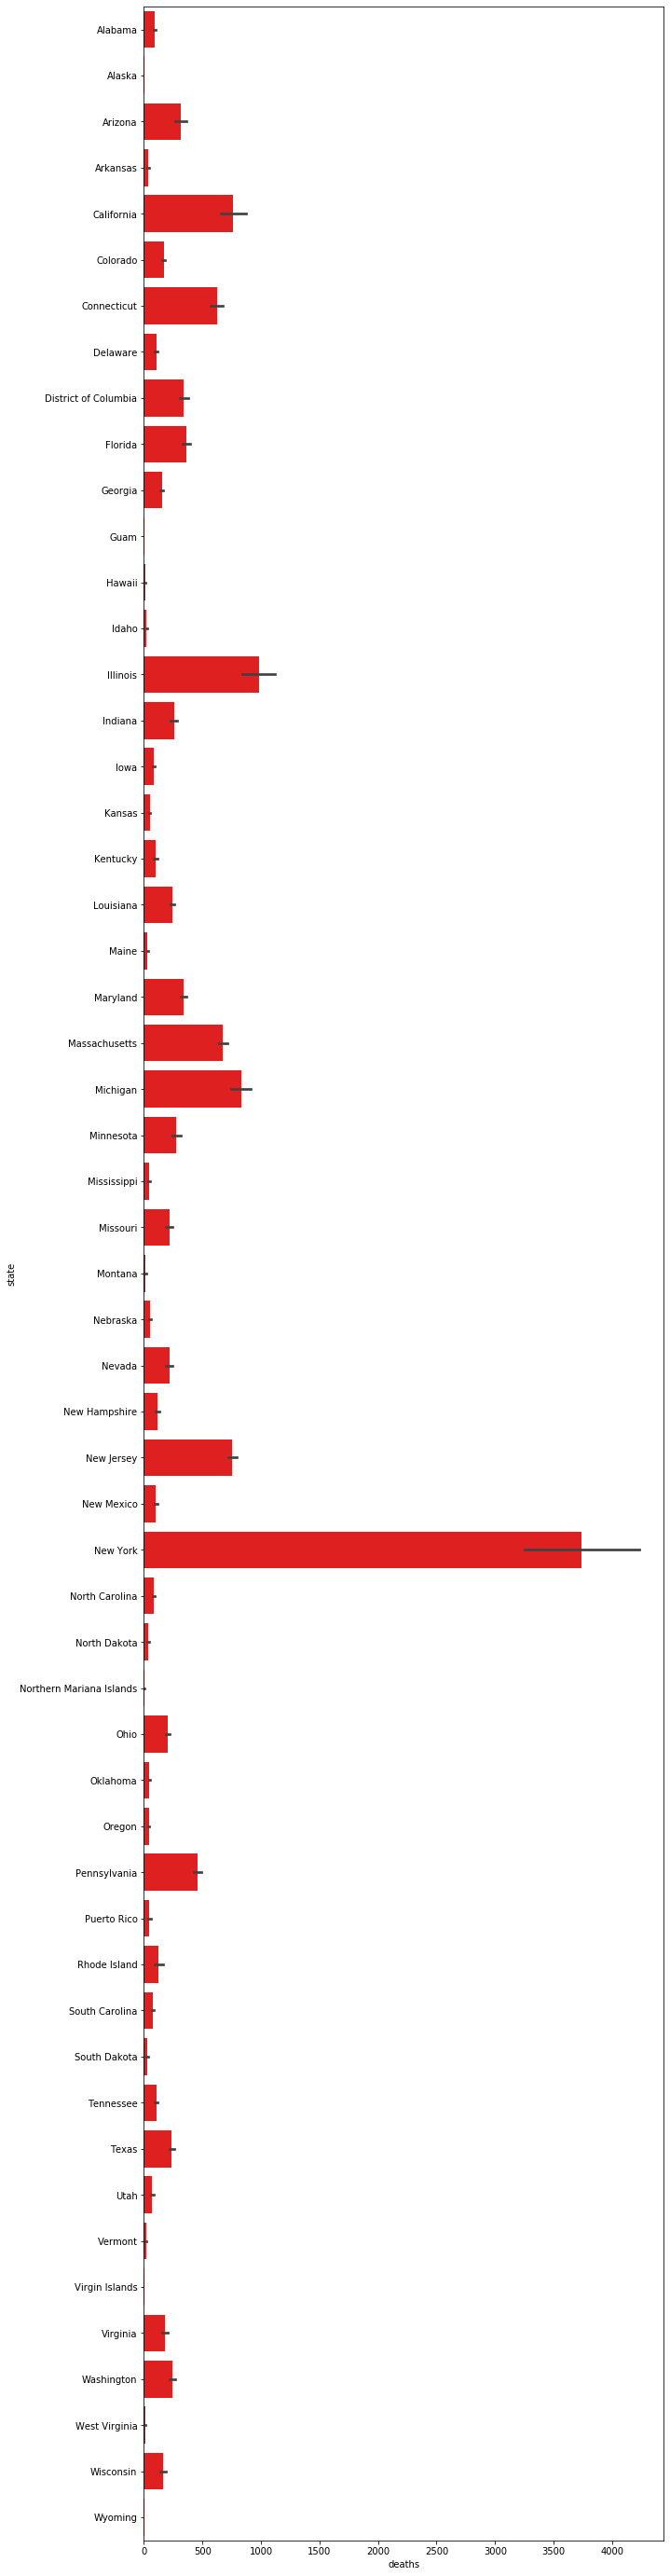

In [177]:
plt.figure(figsize=(10,50))
sns.barplot(data=summary_death, x='deaths',y='state', color='red')

In [178]:
dbed2  = dbed1.groupby(['state','county']).sum().reindex()

In [179]:
dbed2.head(100)

cases  deaths
state   county                  
Alabama Autauga    39785     931
        Baldwin    77258     992
        Barbour    24648     155
        Bibb       13685     103
        Blount     19359      82
...                  ...     ...
Arizona Cochise    45600    1059
        Coconino  156702    8541
        Gila       20504     603
        Graham     10559     201
        Greenlee    1611      70

[100 rows x 2 columns]

In [180]:
result = pd.concat([dcases2, dbed2], axis=1).reindex()

In [181]:
result.head(10)

NUM_LICENSED_BEDS  NUM_STAFFED_BEDS  NUM_ICU_BEDS  \
Alabama Autauga                85.0              55.0           6.0   
        Baldwin               386.0             362.0          51.0   
        Barbour                74.0              30.0           5.0   
        Bibb                   35.0              25.0           4.0   
        Blount                 25.0              25.0           6.0   
        Bullock                61.0              30.0           5.0   
        Butler                 72.0              44.0           7.0   
        Calhoun               486.0             435.0          30.0   
        Chambers              115.0              84.0          15.0   
        Cherokee               60.0              45.0           8.0   

                  ADULT_ICU_BEDS  PEDI_ICU_BEDS  BED_UTILIZATION  \
Alabama Autauga              6.0            0.0         0.623113   
        Baldwin             51.0            0.0         2.248812   
        Barbour              5.0            0.0         0.378721   
        Bibb                 4.0            0.0         0.430904   
        Blount               6.0            0.0         0.499069   
        Bullock              5.0            0.0         0.212877   
        Butler               7.0            0.0         0.187111   
        Calhoun             30.0            0.0         1.294690   
        Chambers            15.0            0.0         0.398726   
        Cherokee             8.0            0.0         0.242532   

                  Potential_Increase_In_Bed_Capac  AVG_VENTILATOR_USAGE  \
Alabama Autauga                              30.0                   2.0   
        Baldwin                              24.0                   8.0   
        Barbour                              44.0                   2.0   
        Bibb                                 10.0                   1.0   
        Blount                                0.0                   2.0   
        Bullock                              31.0                   1.0   
        Butler                               28.0                   2.0   
        Calhoun                              51.0                  15.0   
        Chambers                             31.0                   0.0   
        Cherokee                             15.0                   1.0   

                    cases  deaths  
Alabama Autauga   39785.0   931.0  
        Baldwin   77258.0   992.0  
        Barbour   24648.0   155.0  
        Bibb      13685.0   103.0  
        Blount    19359.0    82.0  
        Bullock   23396.0   661.0  
        Butler    45087.0  1969.0  
        Calhoun   34827.0   424.0  
        Chambers  53165.0  2827.0  
        Cherokee   7521.0   402.0

In [182]:
result.isnull().sum()

NUM_LICENSED_BEDS                  808
NUM_STAFFED_BEDS                   808
NUM_ICU_BEDS                       808
ADULT_ICU_BEDS                     808
PEDI_ICU_BEDS                      808
BED_UTILIZATION                    808
Potential_Increase_In_Bed_Capac    808
AVG_VENTILATOR_USAGE               808
cases                               65
deaths                              65
dtype: int64

In [183]:
result.shape

(3307, 10)

In [184]:
corrD = result.corr()

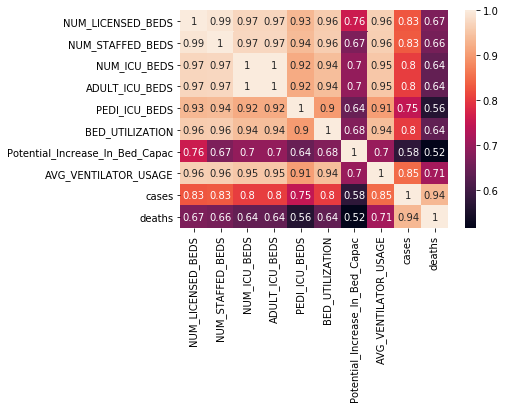

In [185]:
sns.heatmap(corrD, annot = True)
plt.show()

In [186]:
# convert dataframe to csv; save the original cleaned file to notebook instance
result.to_csv('merge-result-cleaned.csv')

In [187]:
result_r = pd.read_csv('merge-result-cleaned-l.csv')

In [188]:
result_r.head(5)

,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE,cases,deaths
0,85.0,55.0,6.0,6.0,0.0,0.623113,30.0,2.0,39785.0,931.0
1,386.0,362.0,51.0,51.0,0.0,2.248812,24.0,8.0,77258.0,992.0
2,74.0,30.0,5.0,5.0,0.0,0.378721,44.0,2.0,24648.0,155.0
3,35.0,25.0,4.0,4.0,0.0,0.430904,10.0,1.0,13685.0,103.0
4,25.0,25.0,6.0,6.0,0.0,0.499069,0.0,2.0,19359.0,82.0


In [189]:
result_r.isnull().sum()

NUM_LICENSED_BEDS                  808
NUM_STAFFED_BEDS                   808
NUM_ICU_BEDS                       808
ADULT_ICU_BEDS                     808
PEDI_ICU_BEDS                      808
BED_UTILIZATION                    808
Potential_Increase_In_Bed_Capac    808
AVG_VENTILATOR_USAGE               808
cases                               65
deaths                              65
dtype: int64

In [190]:
result_n = result_r.dropna()

In [191]:
result_n.isnull().sum()

NUM_LICENSED_BEDS                  0
NUM_STAFFED_BEDS                   0
NUM_ICU_BEDS                       0
ADULT_ICU_BEDS                     0
PEDI_ICU_BEDS                      0
BED_UTILIZATION                    0
Potential_Increase_In_Bed_Capac    0
AVG_VENTILATOR_USAGE               0
cases                              0
deaths                             0
dtype: int64

In [192]:
result_n.shape

(2434, 10)

## **Split Data into Training, Test and Validation datasets**

In [193]:
# convert dataframe to csv; save the original cleaned file to notebook instance
result_n.to_csv('merge-result-cleaned1.csv')

In [194]:
# convert dataframe to csv; save the original cleaned file to notebook instance
result_n.to_csv('merge-result-cleaned-h.csv', header=False, index=False)
# Split the data for training, validation, and test, into separate dataframes of 60%, 20%, 20% respectively
train_data, validation_data, test_data = np.split(result_n.sample(frac=1), [int(.6*len(result_n)), int(.8*len(result_n))])

#convert dfs to .csv and save locally; file is saved to notebook instance
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

## **Upload data into s3 Bucket**

In [195]:
# load files to S3
output_bucket = 'covid.data2020'
prefix = 'cleaned'

boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'merge-result-cleaned-h.csv')).upload_file('merge-result-cleaned-h.csv')
boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'train.csv')).upload_file('train.csv')
boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'validation.csv')).upload_file('validation.csv')
boto3.resource('s3').Bucket(output_bucket).Object(os.path.join(prefix, 'test.csv')).upload_file('test.csv')

## **Training of the Linear Linear Model**

In [196]:
# specify containers
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [200]:
sage_sess = sagemaker.Session()
output_location = 's3://{}/{}/output'.format(output_bucket, prefix)

print("The model output will be loaded to: ", output_location)

linear_model = sagemaker.estimator.Estimator(
                                       container,
                                       role,
                                       train_instance_count = 1, 
                                       train_instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sage_sess)

linear_model.set_hyperparameters(
                           epochs=50,
                           predictor_type='regressor',
                           mini_batch_size=26,
                           learning_rate= 0.0001
                           )

#train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
s3_train_file = 's3://{}/{}/'.format(output_bucket, prefix, 'train.csv')
train_data_file = sagemaker.s3_input(s3_data=s3_train_file, content_type = 'text/csv')

#set evaluation data
s3_eval_file = 's3://{}/{}/'.format(output_bucket, prefix, 'eval.csv')
eval_data_file = sagemaker.s3_input(s3_data=s3_eval_file, content_type = 'text/csv')

#set test data
s3_test_file = 's3://{}/{}/'.format(output_bucket, prefix, 'test.csv')
test_data_file = sagemaker.s3_input(s3_data = s3_test_file, content_type = 'text/csv')

#start the training process
linear_model.fit({'train': train_data_file, 'validation': eval_data_file, 'test': test_data_file}, logs=True)


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


The model output will be loaded to:  s3://covid.data2020/cleaned/output
2020-08-14 19:13:48 Starting - Starting the training job...
2020-08-14 19:13:51 Starting - Launching requested ML instances.........
2020-08-14 19:15:35 Starting - Preparing the instances for training......
2020-08-14 19:16:34 Downloading - Downloading input data...
2020-08-14 19:17:11 Training - Downloading the training image..
2020-08-14 19:17:31 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/14/2020 19:17:34 INFO 140415736805184] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_

# **Deploying Model as a web service**

In [201]:
linear_predictor = linear_model.deploy(initial_instance_count=1,instance_type='ml.c5.4xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

# **Model Validation**

In [202]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [219]:
predicted_result = linear_predictor.predict([42,29,5,5,0.148795,13,1,17701,130]) #1,2,1,0,1,1,0,2,1 0.21830137

print(predicted_result)

{'predictions': [{'score': 49.62276840209961}]}


In [217]:
td = test_data
td = td.drop(['PEDI_ICU_BEDS'], axis=1)
td.head(5)

,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE,cases,deaths
1438,200.0,163.0,24.0,24.0,0.461736,37.0,4.0,6455.0,129.0
2629,838.0,759.0,82.0,82.0,1.221338,79.0,12.0,219423.0,2922.0
2244,41.0,41.0,7.0,7.0,0.157434,0.0,1.0,4343.0,342.0
1567,3116.0,2476.0,280.0,280.0,7.676523,640.0,55.0,111189.0,3001.0
908,200.0,40.0,8.0,8.0,0.783562,160.0,2.0,17604.0,184.0


In [218]:
test_features = np.array(td.values).astype('float32')
for i in test_features:
    prediction = linear_predictor.predict(i)
    print(prediction)

{'predictions': [{'score': 227.70712280273438}]}
{'predictions': [{'score': 852.2322998046875}]}
{'predictions': [{'score': 37.30288314819336}]}
{'predictions': [{'score': 3598.837646484375}]}
{'predictions': [{'score': 343.7577819824219}]}
{'predictions': [{'score': 25.501277923583984}]}
{'predictions': [{'score': 26.41176986694336}]}
{'predictions': [{'score': 25.42654037475586}]}
{'predictions': [{'score': 30.653732299804688}]}
{'predictions': [{'score': 49.622772216796875}]}
{'predictions': [{'score': 481.3678894042969}]}
{'predictions': [{'score': 27.935550689697266}]}
{'predictions': [{'score': 736.9149780273438}]}
{'predictions': [{'score': 270.7419128417969}]}
{'predictions': [{'score': 47.25836944580078}]}
{'predictions': [{'score': 610.2442016601562}]}
{'predictions': [{'score': 1293.89013671875}]}
{'predictions': [{'score': 1824.3277587890625}]}
{'predictions': [{'score': -2.7511043548583984}]}
{'predictions': [{'score': 621.7735595703125}]}
{'predictions': [{'score': 9.9077

In [111]:
import sagemaker
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)